In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn

c:\Users\Z0172725\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Z0172725\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Z0172725\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [46]:
# Import dataset
df = pd.read_csv(r'D:\MTech pro\cfg_european\Data\DATA_AT.csv')
df.Date = pd.to_datetime(df['Date'])

# Setting the date as index will make our time series plots much more understandable.
df.set_index('Date', inplace=True)
k = df.iloc[:,0:24].to_numpy()
n_df = np.reshape(k,(3652*24,1))
# Firstly, we will define a new dataset equal to the existing one, but omitting the last 1 records,
# later we will use the model to predict such values.
ndf = n_df[:-720]
x_test = n_df[-720:]
# We define the length of the training set as 99.5% of the total records inf new dataframe
train_len = math.ceil(len(ndf)*0.995)

In [47]:
# Based on window length training and validation data is generated.
window = 6

# Training dataset generation
train_data = ndf[0:train_len]
X_train = []
Y_train = []
for i in range(window, len(train_data)):
    X_train.append(train_data[i - window:i])
    Y_train.append(train_data[i])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))


# Validation dataset generation
val_data = ndf[train_len - window:]
X_val = []
Y_val = []
for i in range(window, len(val_data)):
    X_val.append(val_data[i - window:i])
    Y_val.append(val_data[i])

X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1]))

In [48]:
# convert to a pytorch tensor
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()
X_val = torch.tensor(X_val).float()
Y_val = torch.tensor(Y_val).float()

In [49]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

torch.Size([86488, 6])
torch.Size([86488, 1])
torch.Size([434, 6])
torch.Size([434, 1])


In [50]:
X_train_actual = X_train
X_val_actual = X_val
Y_train_actual = Y_train
Y_val_actual = Y_val

In [51]:
# Build ANN Medel

n_in, n_h1, n_h2, n_out = window, 25, 15, 1
model = nn.Sequential(
   nn.Linear(n_in, n_h1), # input layer
   #nn.Dropout(0.2),
   nn.ReLU(),
   nn.Linear(n_h1, n_h2), # hidden layer
   #nn.Dropout(0.2),
   #nn.ReLU(),
   #nn.Linear(n_h2, n_h3), # hidden layer
   #nn.Dropout(0.2),
   nn.ReLU(),
   nn.Linear(n_h2, n_out)) # output unit

# lossfun = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)


In [52]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
# Normalising data
def Normalize(x,y):
    return (x-y.min())/(y.max()-y.min())+0.1
def MeanNormalize(x,y):
    return (x-y.mean())/y.std()

# Inverse Normalization
def InverseNorm(x,y):
    return (x-0.1)*(y.max()-y.min())+y.min()

def InverseMeanNorm(x,y):
    return x*(y.std())+y.mean()

In [53]:
# Train the model
def full_gd(model, criterion, optimizer, X_train, Y_train, X_val, Y_val,  epochs=5000):
  # Stuff to store
  train_losses = np.zeros(epochs)
  val_losses = np.zeros(epochs)

  X_train = MeanNormalize(X_train,X_train_actual)
  Y_train = MeanNormalize(Y_train,Y_train_actual)
  X_val = MeanNormalize(X_val,X_val_actual)
  Y_val = MeanNormalize(Y_val,Y_val_actual)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    out_train = model(X_train)
    out_val = model(X_val)

    out_train = InverseMeanNorm(out_train, Y_train_actual)
    out_val = InverseMeanNorm(out_val, Y_val_actual)

    loss_train = criterion(out_train, Y_train_actual)
    loss_val = criterion(out_val, Y_val_actual)
    
    # Backward and optimize
    loss_train.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss_train.item()
    val_losses[it]  = loss_val.item()
      
    if (it + 1) % 500 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}')
  
  return train_losses, val_losses, out_train, out_val

#X_train = torch.from_numpy(X.astype(np.float32))
#Y_train = torch.from_numpy(Y.astype(np.float32).reshape(-1, 1))
train_losses, val_losses, out_train, out_val = full_gd(model, criterion, optimizer, X_train, Y_train, X_val, Y_val)


Epoch 500/5000, Train Loss: 53815.3789, Validation Loss: 76637.2656
Epoch 1000/5000, Train Loss: 41115.7812, Validation Loss: 58738.5703
Epoch 1500/5000, Train Loss: 34260.1641, Validation Loss: 51490.4375
Epoch 2000/5000, Train Loss: 31536.7969, Validation Loss: 50330.0195
Epoch 2500/5000, Train Loss: 30012.9160, Validation Loss: 50058.5469
Epoch 3000/5000, Train Loss: 28365.3633, Validation Loss: 50243.3906
Epoch 3500/5000, Train Loss: 27258.4941, Validation Loss: 49900.6445
Epoch 4000/5000, Train Loss: 26488.7207, Validation Loss: 49127.3281
Epoch 4500/5000, Train Loss: 25792.2832, Validation Loss: 48322.8477
Epoch 5000/5000, Train Loss: 25052.1289, Validation Loss: 47876.1836


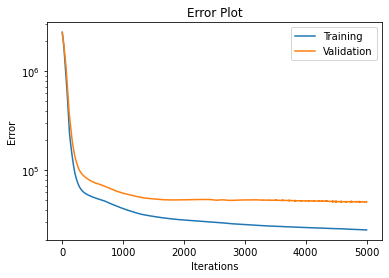

In [54]:
plt.semilogy(train_losses)
plt.semilogy(val_losses)
plt.title("Error Plot")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend(['Training','Validation'])
plt.show()

In [55]:
# MAPE calculation
def MAPE(actual, predicted):
    s=0
    for i in range(len(actual)):
        s = s + abs((predicted[i]-actual[i]))/actual[i]
    return s/len(actual)*100

m_ap_train = MAPE(Y_train_actual, out_train)
m_ap_val = MAPE(Y_val_actual, out_val)

print('Training error RMSE:', np.sqrt(np.sum(train_losses)/len(train_losses)),'MW')
print('Validation error RMSE:', np.sqrt(np.sum(val_losses)/len(val_losses)),'MW')

print('MAPE_train:', torch.sum(m_ap_train))
print('MAPE_val:', torch.sum(m_ap_val))

print('Accuracy_train:', 100-torch.sum(m_ap_train))
print('Accuracy_val:', 100-torch.sum(m_ap_val))

Training error RMSE: 246.89092451171632 MW
Validation error RMSE: 292.34420039516345 MW
MAPE_train: tensor(1.6206, grad_fn=<SumBackward0>)
MAPE_val: tensor(1.9061, grad_fn=<SumBackward0>)
Accuracy_train: tensor(98.3794, grad_fn=<RsubBackward1>)
Accuracy_val: tensor(98.0939, grad_fn=<RsubBackward1>)


In [56]:
out_val = torch.tensor(out_val).float()
out_train = torch.tensor(out_train).float()

C:\Users\Z0172725\AppData\Local\Temp\ipykernel_3356\1324816191.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_val = torch.tensor(out_val).float()
C:\Users\Z0172725\AppData\Local\Temp\ipykernel_3356\1324816191.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_train = torch.tensor(out_train).float()


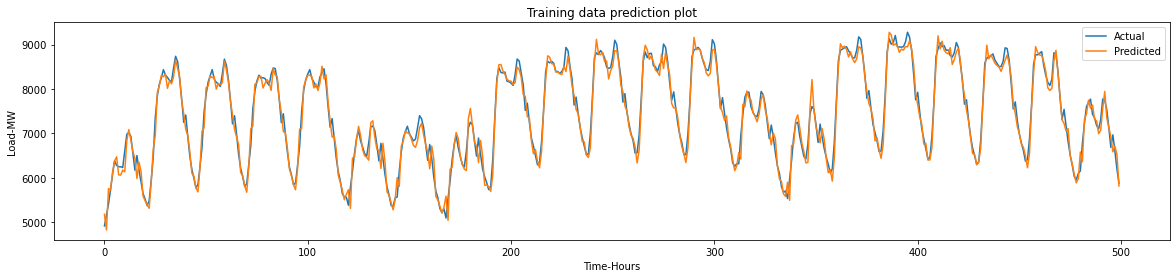

In [57]:
# Plotting training data predictons

plt.figure(figsize=(20,4))
plt.plot(Y_train[0:500])
plt.plot(out_train[0:500])
plt.title("Training data prediction plot")
plt.xlabel("Time-Hours")
plt.ylabel("Load-MW")
plt.legend(['Actual','Predicted'])
plt.show()

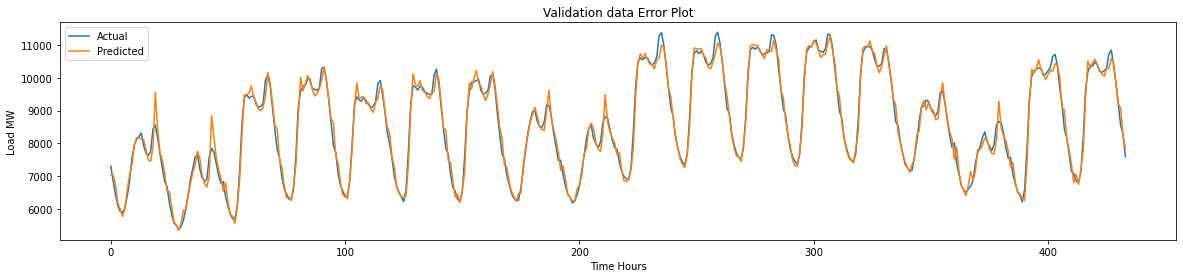

In [58]:
# Plotting Validation data predictions

plt.figure(figsize=(20,4))
plt.plot(Y_val_actual)
plt.plot(out_val)
plt.title("Validation data Error Plot")
plt.xlabel("Time Hours")
plt.ylabel("Load MW")
plt.legend(['Actual','Predicted'])
plt.show()

# Testing

In [59]:
window = 6

# Training dataset generation
testData = x_test
X_test = []
Y_test = []
for i in range(window, len(testData)):
    X_test.append(testData[i - window:i])
    Y_test.append(testData[i])

In [60]:
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

In [61]:
X_test = torch.tensor(X_test).float()
Y_test = torch.tensor(Y_test).float()

In [62]:
X_test_actual = X_test
X_test = MeanNormalize(X_test,X_test_actual)
outTest = model(X_test)
outTest = InverseMeanNorm(outTest, X_test_actual)

In [63]:
testLoss = criterion(outTest, Y_test)
m_ap_test = MAPE(Y_test, outTest)
print('Test error RMSE:', torch.sqrt(torch.sum(testLoss)/len(outTest)),'MW')

m_ap_test = MAPE(Y_test, outTest)
print('MAPE_test = ', torch.sum(m_ap_test))
print('Accuracy_test = ',100-torch.sum(m_ap_test))

Test error RMSE: tensor(7.8960, grad_fn=<SqrtBackward0>) MW
MAPE_test =  tensor(1.8677, grad_fn=<SumBackward0>)
Accuracy_test =  tensor(98.1323, grad_fn=<RsubBackward1>)


In [64]:
outTest = torch.tensor(outTest).float()
out_train = torch.tensor(out_train).float()

C:\Users\Z0172725\AppData\Local\Temp\ipykernel_3356\804635892.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outTest = torch.tensor(outTest).float()
C:\Users\Z0172725\AppData\Local\Temp\ipykernel_3356\804635892.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_train = torch.tensor(out_train).float()


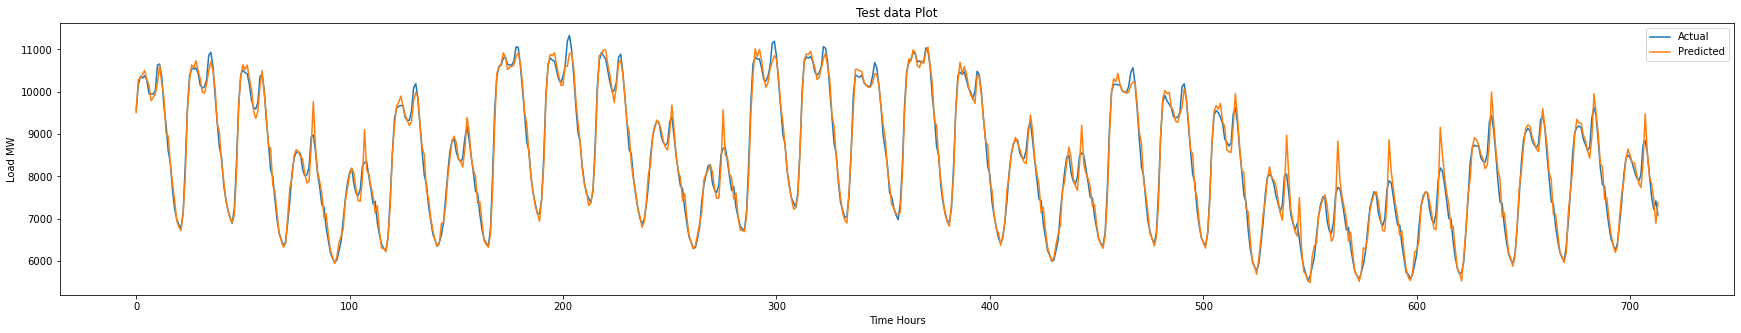

In [65]:
plt.figure(figsize=(30,5))
plt.plot(Y_test)
plt.plot(outTest)
plt.title("Test data Plot")
plt.xlabel("Time Hours")
plt.ylabel("Load MW")
plt.legend(['Actual','Predicted'])
plt.show()

# Saving the Model

In [362]:
torch.save(model.state_dict(), "your_model_path.pt")

In [363]:
# load your model architecture/module
#model = YourModel()
# fill your architecture with the trained weights
model.load_state_dict(torch.load("your_model_path.pt"))

<All keys matched successfully>